In [1]:
import os
import getpass
import numpy as np
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Random Forrest

## 1. Load data

In [4]:
# Gå et niveau op og naviger til mappen "Data"
os.chdir('../Data')

In [5]:
# Import features
file_path = 'Merged_dataset.csv'
df = pd.read_csv("merged_dataset.csv", sep=";", parse_dates=["Date"])
df.set_index("Date", inplace=True)
df.shape

(156, 184)

In [6]:
y = df.iloc[:, 0]   # første kolonne = inflation
X = df.iloc[:, 1:]  # resten = forklarende variable

# Tjek dimensioner
print("y shape:", y.shape)
print("X shape:", X.shape)

y shape: (156,)
X shape: (156, 183)


## 2. Imputer manglende værdier

In [8]:
imputer = SimpleImputer(strategy="median")  # Eller "median"

X_imputed = imputer.fit_transform(X)  # Imputer NaN i hele datasættet

# Konverter tilbage til DataFrame med kolonnenavne
X = pd.DataFrame(X_imputed, columns=X.columns, index = df.index)

## 3. Standardiser data 

In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Run Simple Random Forrest model

In [12]:
# Split i train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# Træn Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [14]:
# Forudsig
y_pred = model.predict(X_test)

# Evaluer
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse:.2f}')
print(f'R²: {r2:.2f}')

# Feature importance plot
importances = model.feature_importances_
feature_names = X.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sorter fra vigtigst til mindst vigtigst
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Vis top 10 (eller hele tabellen hvis du vil)
importance_df.head(10)

MSE: 0.13
R²: 0.96


,Feature,Importance
119,Ledige dagpengemodtagere,0.291501
169,inflation_rolling_mean3,0.203361
166,inflation_lag1,0.156152
118,Bruttoledige,0.098762
10,"04.5 Elektricitet, gas og andet brændsel",0.036083
108,"Danmarks økonomiske situation i dag, sammenlig...",0.027537
111,"Priser i dag, sammenlignet med for et år siden",0.018452
58,Andre varer,0.017918
168,inflation_lag3,0.016955
49,P.71 Import af varer,0.016912


# Forecast 1

In [16]:
# Skaler X (Random Forest kræver det ikke, men for konsistens)

forecast_horizons = 12
rf_models = {}

#for h in range(1, forecast_horizons + 1):
for h in range(0, forecast_horizons):

    print(f"\n=== Horizon {h+1} ===")
        
    y_shifted = y.shift(-h)
    y_shifted = y_shifted.dropna()
    
    X_train = X_scaled[:len(y_shifted)]
    y_train = y_shifted
    
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    rf_models[h] = model
    
    print(f"Antal træningsobservationer: {len(y_train)}")
    print(f"Antal Regressor: {model.n_features_in_:.5f}") 
    


=== Horizon 1 ===
Antal træningsobservationer: 156
Antal Regressor: 183.00000

=== Horizon 2 ===
Antal træningsobservationer: 155
Antal Regressor: 183.00000

=== Horizon 3 ===
Antal træningsobservationer: 154
Antal Regressor: 183.00000

=== Horizon 4 ===
Antal træningsobservationer: 153
Antal Regressor: 183.00000

=== Horizon 5 ===
Antal træningsobservationer: 152
Antal Regressor: 183.00000

=== Horizon 6 ===
Antal træningsobservationer: 151
Antal Regressor: 183.00000

=== Horizon 7 ===
Antal træningsobservationer: 150
Antal Regressor: 183.00000

=== Horizon 8 ===
Antal træningsobservationer: 149
Antal Regressor: 183.00000

=== Horizon 9 ===
Antal træningsobservationer: 148
Antal Regressor: 183.00000

=== Horizon 10 ===
Antal træningsobservationer: 147
Antal Regressor: 183.00000

=== Horizon 11 ===
Antal træningsobservationer: 146
Antal Regressor: 183.00000

=== Horizon 12 ===
Antal træningsobservationer: 145
Antal Regressor: 183.00000


In [17]:
# Tag seneste observation (det du forudsiger ud fra)
latest_data_df = X.iloc[[-1]]  # Beholder det som DataFrame med kolonnenavne
latest_data_scaled = scaler.transform(latest_data_df)
rf_forecasts = {}

#for h in range(1, forecast_horizons+1):# with January
for h in range(0, forecast_horizons):
    forecast = rf_models[h].predict(latest_data_scaled)
    rf_forecasts[h] = forecast[0]  # Gem som float

In [18]:
#  Udskriv resultater
forecast_df = pd.DataFrame(list(rf_forecasts.items()), columns=["Måneder frem", "Inflationsforecast"])
print("\n Inflationsforecast for de næste 12 måneder:")
forecast_df


 Inflationsforecast for de næste 12 måneder:


,Måneder frem,Inflationsforecast
0,0,1.86190
1,1,2.29270
2,2,1.39330
3,3,1.54799
4,4,2.08841
5,5,2.97783
6,6,6.72217
7,7,6.43488
8,8,5.56967
9,9,3.23340


# Funktion

In [20]:
def RandomForrest_Forecaster(X, y, forecast_horizon, scaler, last_observation_date):
    
    
    X = X.loc[:last_observation_date]
    y = y.loc[:last_observation_date]
    
    X_scaled = scaler.transform(X)

    rf_models = {}

    for h in range(0, forecast_horizon):

        print(f"\n=== Horizon {h} ===")
        y_shifted = y.shift(-h)
        y_shifted = y_shifted.dropna()
    
        X_train = X_scaled[:len(y_shifted)]
        y_train = y_shifted
    
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)
    
        rf_models[h] = model
    
        print(f"Antal træningsobservationer: {len(y_train)}")
        print(f"Antal Regressor: {model.n_features_in_:.5f}") 
        
    # Tag seneste observation (det du forudsiger ud fra)
    #latest_data_df = X.iloc[[-1]]  # Beholder det som DataFrame med kolonnenavne
    #latest_data_scaled = scaler.transform(latest_data_df)
    
    X_t = X.loc[[last_observation_date]]
    X_t_scaled = scaler.transform(X_t)
    
    rf_forecasts = {}

    for h in range(0, forecast_horizon):
        forecast = rf_models[h].predict(X_t_scaled)
        rf_forecasts[h] = forecast[0]  # Gem som float
        
     # 4. Datoetiketter
    start_date = pd.to_datetime(last_observation_date) + pd.DateOffset(months=1)
    forecast_dates = [start_date + pd.DateOffset(months=h) for h in rf_forecasts.keys()]

    #  Print datoer for de forudsagte måneder
    print("\nForudsagte måneder:")
    for date in forecast_dates:
        print(date.strftime("%Y-%m"))
        
        
    forecast_df = pd.DataFrame({
        "Dato": forecast_dates,
        "Inflationsforecast": list(rf_forecasts.values())
    })
    
    return forecast_df

In [21]:
forecast_horizon = 5
%time forecast_df = RandomForrest_Forecaster(X, y, forecast_horizon, scaler, last_observation_date="2024-12-01")


=== Horizon 0 ===
Antal træningsobservationer: 156
Antal Regressor: 183.00000

=== Horizon 1 ===
Antal træningsobservationer: 155
Antal Regressor: 183.00000

=== Horizon 2 ===
Antal træningsobservationer: 154
Antal Regressor: 183.00000

=== Horizon 3 ===
Antal træningsobservationer: 153
Antal Regressor: 183.00000

=== Horizon 4 ===
Antal træningsobservationer: 152
Antal Regressor: 183.00000

Forudsagte måneder:
2025-01
2025-02
2025-03
2025-04
2025-05
CPU times: user 4.28 s, sys: 38.7 ms, total: 4.32 s
Wall time: 4.32 s


In [22]:
forecast_df

,Dato,Inflationsforecast
0,2025-01-01,1.86190
1,2025-02-01,2.29270
2,2025-03-01,1.39330
3,2025-04-01,1.54799
4,2025-05-01,2.08841


# Forecast with a Rolling Window

In [24]:
def RandomForest_Forecaster_Rolling(X, y, forecast_horizon, last_observation_date, scaler, window_length=108, verbose=True):
    """
    Forecast inflation using one Random Forest model per horizon (direct forecast), based on Garcia et al. (2017)
    
    Args:
        X: DataFrame of predictors
        y: Series of target variable
        forecast_horizon: int, how many steps ahead to forecast (e.g. 12)
        last_observation_date: str or Timestamp, end of training data and point of forecast
        scaler: a fitted sklearn scaler (no data leakage!)
        window_length: int, number of time steps in rolling window (default 108 = 9 years of monthly data)
    """

    # 1. Begræns datasættet til kun at inkludere real-time tilgængelige observationer (op til last_observation_date)
    X = X.loc[:last_observation_date]
    y = y.loc[:last_observation_date]

    # 2. Definér rolling window
    if len(X) < window_length:
        raise ValueError("Not enough data for the chosen rolling window length.")
    
    X_window = X.iloc[-window_length:]
    y_window = y.iloc[-window_length:]

    # 3. Træn en model per horisont (direct forecast approach)
    rf_models = {}

    for h in range(forecast_horizon):
        if verbose: 
            print(f"\n=== Horisont h={h+1} ===")
        
        # Laver y_{t+h}
        y_shifted = y_window.shift(-h).dropna()

        # Matcher X til y
        X_train = X_window.iloc[:len(y_shifted)]
        y_train = y_shifted

        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(scaler.transform(X_train), y_train)

        rf_models[h] = model

        if verbose: 
            print(f"Antal træningsobservationer: {len(y_train)}")
            print(f"Antal regressorer: {model.n_features_in_}")

    # 4. Lav forecast fra X_t (real-time available data)
    X_t = X.loc[[last_observation_date]]  # Real-time input
    X_t_scaled = scaler.transform(X_t)

    rf_forecasts = {}

    for h in range(forecast_horizon):
        forecast = rf_models[h].predict(X_t_scaled)
        rf_forecasts[h] = forecast[0]  # Gem som float

    # 5. Generér datoer
    start_date = pd.to_datetime(last_observation_date) + pd.DateOffset(months=1)
    forecast_dates = [start_date + pd.DateOffset(months=h) for h in rf_forecasts.keys()]

    forecast_df = pd.DataFrame({
        "Dato": forecast_dates,
        "Inflationsforecast": list(rf_forecasts.values()),
        "Horizon": list(rf_forecasts.keys())
    })

    if verbose: 
        print("\nForudsagte måneder:")
        for date in forecast_dates:
            print(date.strftime("%Y-%m"))

    return forecast_df

In [25]:
forecast_horizon = 12 # 1 year
window_length = 9*12 # 12 Years
last_observation_date = "2024-12-01"

forecast_df = RandomForest_Forecaster_Rolling(X, y, forecast_horizon, last_observation_date, scaler, window_length, verbose = True)



=== Horisont h=1 ===
Antal træningsobservationer: 108
Antal regressorer: 183

=== Horisont h=2 ===
Antal træningsobservationer: 107
Antal regressorer: 183

=== Horisont h=3 ===
Antal træningsobservationer: 106
Antal regressorer: 183

=== Horisont h=4 ===
Antal træningsobservationer: 105
Antal regressorer: 183

=== Horisont h=5 ===
Antal træningsobservationer: 104
Antal regressorer: 183

=== Horisont h=6 ===
Antal træningsobservationer: 103
Antal regressorer: 183

=== Horisont h=7 ===
Antal træningsobservationer: 102
Antal regressorer: 183

=== Horisont h=8 ===
Antal træningsobservationer: 101
Antal regressorer: 183

=== Horisont h=9 ===
Antal træningsobservationer: 100
Antal regressorer: 183

=== Horisont h=10 ===
Antal træningsobservationer: 99
Antal regressorer: 183

=== Horisont h=11 ===
Antal træningsobservationer: 98
Antal regressorer: 183

=== Horisont h=12 ===
Antal træningsobservationer: 97
Antal regressorer: 183

Forudsagte måneder:
2025-01
2025-02
2025-03
2025-04
2025-05
202

In [26]:
forecast_df

,Dato,Inflationsforecast,Horizon
0,2025-01-01,1.87561,0
1,2025-02-01,2.10115,1
2,2025-03-01,2.05751,2
3,2025-04-01,1.82840,3
4,2025-05-01,2.25136,4
5,2025-06-01,3.10169,5
6,2025-07-01,6.84358,6
7,2025-08-01,6.71028,7
8,2025-09-01,5.84047,8
9,2025-10-01,3.61936,9


# Rolling Forecasts

In [28]:
def run_rolling_forecast(X, y, forecast_horizon=12, start_date="2012-01", end_date="2015-12", window_length=72):
    """
    Kører rolling real-time forecast med Random Forest, én forecast per måned (med 12 horisonter per gang)
    """

    all_forecasts = []

    forecast_dates = pd.date_range(start=start_date, end=end_date, freq="MS")

    for date in forecast_dates:
        print(f"\n=== Forecast lavet i: {date.strftime('%Y-%m')} ===")

        # Real-time datasæt
        X_train = X.loc[:date]
        y_train = y.loc[:date]

        if len(X_train) < window_length:
            print("Springer over pga. for lidt data.")
            continue

        # Skaler træningsdata (rolling window)
        scaler = StandardScaler()
        scaler.fit(X_train.iloc[-window_length:])

        # Lav forecast for 12 horisonter
        forecast_df = RandomForest_Forecaster_Rolling(
            X=X,
            y=y,
            forecast_horizon=forecast_horizon,
            last_observation_date=date,
            scaler=scaler,
            window_length=window_length, 
            verbose=False
        )

        forecast_df["Forecast_made_in"] = date  # hvornår forecast blev lavet
        all_forecasts.append(forecast_df)

    all_forecasts_df = pd.concat(all_forecasts, ignore_index=True)
    return all_forecasts_df


In [29]:
forecast_results = run_rolling_forecast(X, y, forecast_horizon=12, start_date="2023-01-01", end_date="2024-12-01")


=== Forecast lavet i: 2023-01 ===

=== Forecast lavet i: 2023-02 ===

=== Forecast lavet i: 2023-03 ===

=== Forecast lavet i: 2023-04 ===

=== Forecast lavet i: 2023-05 ===

=== Forecast lavet i: 2023-06 ===

=== Forecast lavet i: 2023-07 ===

=== Forecast lavet i: 2023-08 ===

=== Forecast lavet i: 2023-09 ===

=== Forecast lavet i: 2023-10 ===

=== Forecast lavet i: 2023-11 ===

=== Forecast lavet i: 2023-12 ===

=== Forecast lavet i: 2024-01 ===

=== Forecast lavet i: 2024-02 ===

=== Forecast lavet i: 2024-03 ===

=== Forecast lavet i: 2024-04 ===

=== Forecast lavet i: 2024-05 ===

=== Forecast lavet i: 2024-06 ===

=== Forecast lavet i: 2024-07 ===

=== Forecast lavet i: 2024-08 ===

=== Forecast lavet i: 2024-09 ===

=== Forecast lavet i: 2024-10 ===

=== Forecast lavet i: 2024-11 ===

=== Forecast lavet i: 2024-12 ===


In [30]:
forecast_results

,Dato,Inflationsforecast,Horizon,Forecast_made_in
0,2023-02-01,7.96950,0,2023-01-01
1,2023-03-01,8.29564,1,2023-01-01
2,2023-04-01,7.94395,2,2023-01-01
3,2023-05-01,7.87226,3,2023-01-01
4,2023-06-01,8.38666,4,2023-01-01
...,...,...,...,...
283,2025-08-01,7.03478,7,2024-12-01
284,2025-09-01,6.50227,8,2024-12-01
285,2025-10-01,4.37135,9,2024-12-01
286,2025-11-01,1.76962,10,2024-12-01


In [31]:
def evaluate_forecasts(forecast_df, y):
    """
    Matcher forecast med y_true og returnerer RMSE og MAE pr. horisont
    """
    # Merge forecast og faktisk inflation
    merged = forecast_df.merge(
        y.rename("y_true"), 
        left_on="Dato", 
        right_index=True,
        how="left"
    )

    # Filtrer ud fremtid hvor vi ikke har faktisk inflation
    merged = merged.dropna(subset=["y_true"])

    # Beregn fejl
    merged["error"] = merged["Inflationsforecast"] - merged["y_true"]
    merged["abs_error"] = merged["error"].abs()
    merged["squared_error"] = merged["error"] ** 2

    # Evaluer pr. horisont
    evaluation = merged.groupby("Horizon").agg(
        MAE=("abs_error", "mean"),
        RMSE=("squared_error", lambda x: (x.mean())**0.5),
        N_obs=("y_true", "count")
    ).reset_index()

    return evaluation, merged


In [32]:
eval_df, merged_df = evaluate_forecasts(forecast_results, y)
eval_df

,Horizon,MAE,RMSE,N_obs
0,0,0.731433,1.045002,23
1,1,1.383804,1.858051,22
2,2,1.720464,2.230245,21
3,3,2.281543,2.695686,20
4,4,3.256227,3.646843,19
5,5,3.127913,3.683381,18
6,6,2.852638,3.688175,17
7,7,3.431091,4.393185,16
8,8,5.154439,5.579253,15
9,9,5.578984,5.760263,14


Note: det giver mening at N_obs flader med fordi de ligger ude i fremtiden

## results

In [35]:
h1 = merged_df[merged_df["Horizon"] == 0]
h1

,Dato,Inflationsforecast,Horizon,Forecast_made_in,y_true,error,abs_error,squared_error
0,2023-02-01,7.96950,0,2023-01-01,7.601,0.36850,0.36850,0.135792
12,2023-03-01,7.81484,0,2023-02-01,6.733,1.08184,1.08184,1.170378
24,2023-04-01,7.00110,0,2023-03-01,5.282,1.71910,1.71910,2.955305
36,2023-05-01,5.87777,0,2023-04-01,2.928,2.94977,2.94977,8.701143
48,2023-06-01,3.88933,0,2023-05-01,2.465,1.42433,1.42433,2.028716
60,2023-07-01,3.08092,0,2023-06-01,3.133,-0.05208,0.05208,0.002712
72,2023-08-01,3.21778,0,2023-07-01,2.437,0.78078,0.78078,0.609617
84,2023-09-01,2.70456,0,2023-08-01,0.859,1.84556,1.84556,3.406092
96,2023-10-01,1.56065,0,2023-09-01,0.085,1.47565,1.47565,2.177543
108,2023-11-01,0.86457,0,2023-10-01,0.600,0.26457,0.26457,0.069997


1. Husk, at Python-indeksering starter ved 0. 
   Det betyder, at når modellen intern bruger h=0, så svarer det til forecast for 1 måned frem (altså Horizon = 1 i output).

2. For hver måned, hvor vi laver et forecast (fx jan, feb, mar, ...), forudsiger vi inflation 12 måneder frem.
   Det betyder, at vi får 12 forecasts per måned.
   Det samlede antal observationer i forecast-tabellen er derfor:
   antal måneder × forecast-horisont = total antal forecasts

   Eksempel:
   - Forecasts laves fra jan 2023 til dec 2024 → 24 måneder
   - 12 forecast-horisonter per måned → 24 × 12 = 288 observationer
   (se `forecast_results`)

3. Horizon angiver, hvor langt ude i fremtiden et forecast gælder – målt i måneder.
   - Horizon = 1 → forudsiger næste måneds inflation (lavet i måned t → gælder måned t+1)
   - Horizon = 2 → forudsiger to måneder frem (lavet i t → gælder t+2)
   osv.
   (Bemærk: når koden bruger `h = 0`, betyder det forecast for én måned frem)

4. Ud fra `eval_df` kan vi se, at Random Forest præsterer bedst ved korte horisonter – særligt de første 3 måneder (Horizon = 1–3).
   Her er fejlene (MAE/RMSE) lavest, mens de stiger ved længere horisonter.


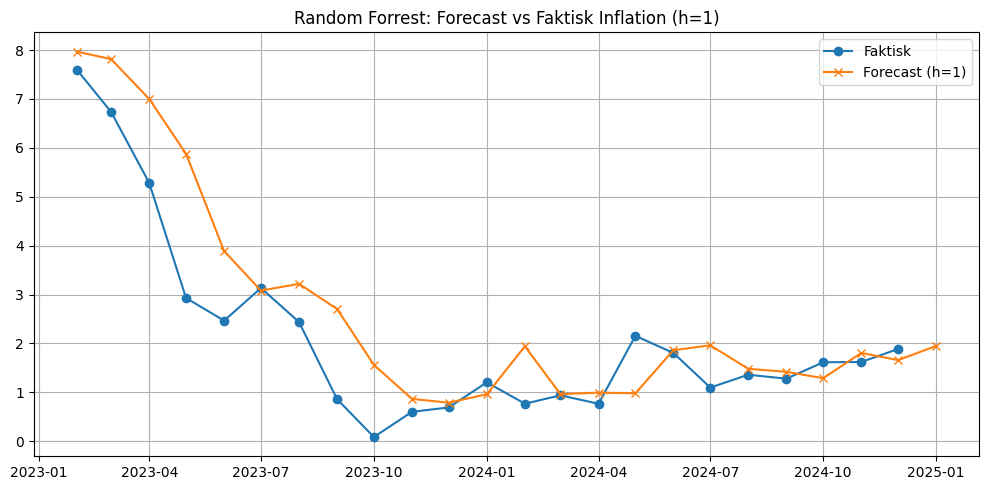

In [82]:
plt.figure(figsize=(10, 5))
plt.plot(h1["Dato"], h1["y_true"], label="Faktisk", marker="o")
plt.plot(h1["Dato"], h1["Inflationsforecast"], label="Forecast (h=1)", marker="x")
plt.legend()
plt.title("Random Forrest: Forecast vs Faktisk Inflation (h=1)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Forcast into 2025

In [39]:
def run_rolling_forecast(X, y, forecast_horizon=12, start_date="2012-01", end_date="2015-12", window_length=72):
    """
    Kører rolling real-time forecast med Random Forest, én forecast per måned (med 12 horisonter per gang)
    """

    all_forecasts = []

    end_date = min(pd.to_datetime(end_date), X.index.max())
    forecast_dates = pd.date_range(start=start_date, end=end_date, freq="MS")

    for date in forecast_dates:
        print(f"\n=== Forecast lavet i: {date.strftime('%Y-%m')} ===")

        # Real-time datasæt
        X_train = X.loc[:date]
        y_train = y.loc[:date]

        if len(X_train) < window_length:
            print("Springer over pga. for lidt data.")
            continue

        # Skaler træningsdata (rolling window)
        scaler = StandardScaler()
        scaler.fit(X_train.iloc[-window_length:])

        # Lav forecast for 12 horisonter
        forecast_df = RandomForest_Forecaster_Rolling(
            X=X,
            y=y,
            forecast_horizon=forecast_horizon,
            last_observation_date=date,
            scaler=scaler,
            window_length=window_length, 
            verbose=False
        )

        forecast_df["Forecast_made_in"] = date  # hvornår forecast blev lavet
        all_forecasts.append(forecast_df)

    all_forecasts_df = pd.concat(all_forecasts, ignore_index=True)
    return all_forecasts_df


In [40]:
forecast_results = run_rolling_forecast(X, y, forecast_horizon=12, start_date="2023-01-01", end_date="2025-12-01")


=== Forecast lavet i: 2023-01 ===

=== Forecast lavet i: 2023-02 ===

=== Forecast lavet i: 2023-03 ===

=== Forecast lavet i: 2023-04 ===

=== Forecast lavet i: 2023-05 ===

=== Forecast lavet i: 2023-06 ===

=== Forecast lavet i: 2023-07 ===

=== Forecast lavet i: 2023-08 ===

=== Forecast lavet i: 2023-09 ===

=== Forecast lavet i: 2023-10 ===

=== Forecast lavet i: 2023-11 ===

=== Forecast lavet i: 2023-12 ===

=== Forecast lavet i: 2024-01 ===

=== Forecast lavet i: 2024-02 ===

=== Forecast lavet i: 2024-03 ===

=== Forecast lavet i: 2024-04 ===

=== Forecast lavet i: 2024-05 ===

=== Forecast lavet i: 2024-06 ===

=== Forecast lavet i: 2024-07 ===

=== Forecast lavet i: 2024-08 ===

=== Forecast lavet i: 2024-09 ===

=== Forecast lavet i: 2024-10 ===

=== Forecast lavet i: 2024-11 ===

=== Forecast lavet i: 2024-12 ===


In [41]:
forecast_results

,Dato,Inflationsforecast,Horizon,Forecast_made_in
0,2023-02-01,7.96950,0,2023-01-01
1,2023-03-01,8.29564,1,2023-01-01
2,2023-04-01,7.94395,2,2023-01-01
3,2023-05-01,7.87226,3,2023-01-01
4,2023-06-01,8.38666,4,2023-01-01
...,...,...,...,...
283,2025-08-01,7.03478,7,2024-12-01
284,2025-09-01,6.50227,8,2024-12-01
285,2025-10-01,4.37135,9,2024-12-01
286,2025-11-01,1.76962,10,2024-12-01


In [42]:
def evaluate_future_forecast(forecast_df, y):
    """
    Matcher forecast med y_true hvis muligt, og returnerer et DataFrame
    med både historiske og fremtidige forecasts.
    
    Tilføjer kolonne 'y_true' og 'Available' (True/False).
    """
    # Merge y_true på Dato
    merged = forecast_df.merge(
        y.rename("y_true"),
        left_on="Dato",
        right_index=True,
        how="left"
    )

    # Angiv om vi har faktisk værdi (realiseret inflation)
    merged["Available"] = ~merged["y_true"].isna()

    # Tilføj fejlberegninger, men kun hvor vi har y_true
    merged["error"] = merged["Inflationsforecast"] - merged["y_true"]
    merged["abs_error"] = merged["error"].abs()
    merged["squared_error"] = merged["error"] ** 2

    # Ekstra: Hvor mange gange er en måned blevet forecastet?
    month_counts = merged.groupby("Dato").size().rename("Forecasts_for_month")
    merged = merged.merge(month_counts, on="Dato", how="left")

    return merged


In [43]:
merged_df = evaluate_future_forecast(forecast_results, y)
merged_df

,Dato,Inflationsforecast,Horizon,Forecast_made_in,y_true,Available,error,abs_error,squared_error,Forecasts_for_month
0,2023-02-01,7.96950,0,2023-01-01,7.601,True,0.36850,0.36850,0.135792,1
1,2023-03-01,8.29564,1,2023-01-01,6.733,True,1.56264,1.56264,2.441844,2
2,2023-04-01,7.94395,2,2023-01-01,5.282,True,2.66195,2.66195,7.085978,3
3,2023-05-01,7.87226,3,2023-01-01,2.928,True,4.94426,4.94426,24.445707,4
4,2023-06-01,8.38666,4,2023-01-01,2.465,True,5.92166,5.92166,35.066057,5
...,...,...,...,...,...,...,...,...,...,...
283,2025-08-01,7.03478,7,2024-12-01,NaN,False,NaN,NaN,NaN,5
284,2025-09-01,6.50227,8,2024-12-01,NaN,False,NaN,NaN,NaN,4
285,2025-10-01,4.37135,9,2024-12-01,NaN,False,NaN,NaN,NaN,3
286,2025-11-01,1.76962,10,2024-12-01,NaN,False,NaN,NaN,NaN,2


In [44]:
h1 = merged_df[merged_df["Horizon"] == 0]
h1

,Dato,Inflationsforecast,Horizon,Forecast_made_in,y_true,Available,error,abs_error,squared_error,Forecasts_for_month
0,2023-02-01,7.96950,0,2023-01-01,7.601,True,0.36850,0.36850,0.135792,1
12,2023-03-01,7.81484,0,2023-02-01,6.733,True,1.08184,1.08184,1.170378,2
24,2023-04-01,7.00110,0,2023-03-01,5.282,True,1.71910,1.71910,2.955305,3
36,2023-05-01,5.87777,0,2023-04-01,2.928,True,2.94977,2.94977,8.701143,4
48,2023-06-01,3.88933,0,2023-05-01,2.465,True,1.42433,1.42433,2.028716,5
60,2023-07-01,3.08092,0,2023-06-01,3.133,True,-0.05208,0.05208,0.002712,6
72,2023-08-01,3.21778,0,2023-07-01,2.437,True,0.78078,0.78078,0.609617,7
84,2023-09-01,2.70456,0,2023-08-01,0.859,True,1.84556,1.84556,3.406092,8
96,2023-10-01,1.56065,0,2023-09-01,0.085,True,1.47565,1.47565,2.177543,9
108,2023-11-01,0.86457,0,2023-10-01,0.600,True,0.26457,0.26457,0.069997,10


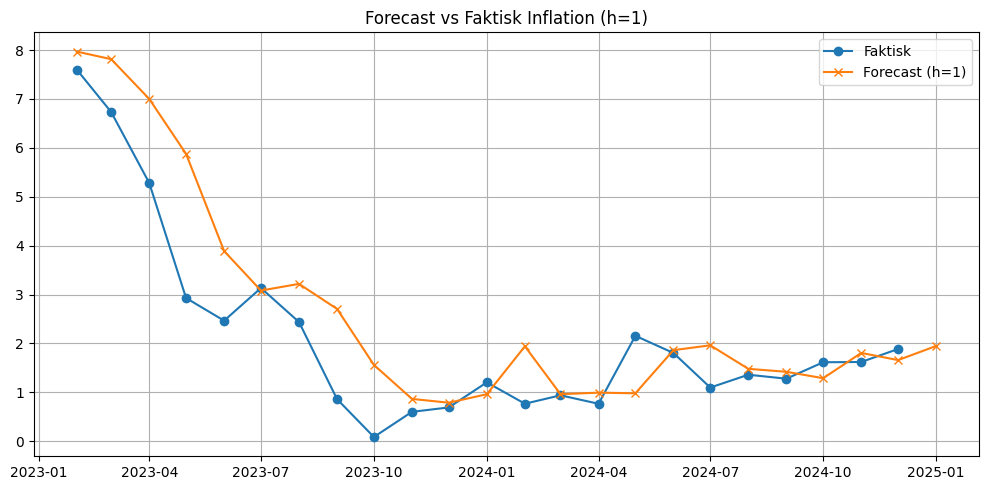

In [45]:
plt.figure(figsize=(10, 5))
plt.plot(h1["Dato"], h1["y_true"], label="Faktisk", marker="o")
plt.plot(h1["Dato"], h1["Inflationsforecast"], label="Forecast (h=1)", marker="x")
plt.legend()
plt.title("Forecast vs Faktisk Inflation (h=1)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [46]:
forecasts_2025 = merged_df[
    (merged_df["Dato"] >= "2025-01-01") & (merged_df["Dato"] <= "2025-12-01")
]

In [47]:
forecasts_2025

,Dato,Inflationsforecast,Horizon,Forecast_made_in,y_true,Available,error,abs_error,squared_error,Forecasts_for_month
155,2025-01-01,1.23895,11,2024-01-01,NaN,False,NaN,NaN,NaN,12
166,2025-01-01,2.62770,10,2024-02-01,NaN,False,NaN,NaN,NaN,12
167,2025-02-01,1.41597,11,2024-02-01,NaN,False,NaN,NaN,NaN,11
177,2025-01-01,3.70794,9,2024-03-01,NaN,False,NaN,NaN,NaN,12
178,2025-02-01,1.97174,10,2024-03-01,NaN,False,NaN,NaN,NaN,11
...,...,...,...,...,...,...,...,...,...,...
283,2025-08-01,7.03478,7,2024-12-01,NaN,False,NaN,NaN,NaN,5
284,2025-09-01,6.50227,8,2024-12-01,NaN,False,NaN,NaN,NaN,4
285,2025-10-01,4.37135,9,2024-12-01,NaN,False,NaN,NaN,NaN,3
286,2025-11-01,1.76962,10,2024-12-01,NaN,False,NaN,NaN,NaN,2


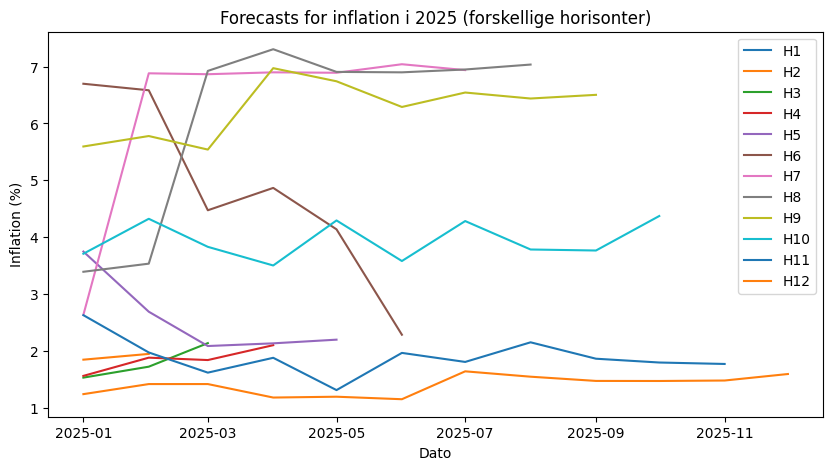

In [48]:
fig, ax = plt.subplots(figsize=(10, 5))

for h in range(12):  # Horizon 0 to 11
    h_df = forecasts_2025[forecasts_2025["Horizon"] == h]
    ax.plot(h_df["Dato"], h_df["Inflationsforecast"], label=f"H{h+1}")

ax.set_title("Forecasts for inflation i 2025 (forskellige horisonter)")
ax.set_ylabel("Inflation (%)")
ax.set_xlabel("Dato")
ax.legend()
plt.show()


In [49]:
forecast_2025 = merged_df[
    (merged_df["Forecast_made_in"] == "2024-12-01")  # sidste kendte forecast
]
forecast_2025

,Dato,Inflationsforecast,Horizon,Forecast_made_in,y_true,Available,error,abs_error,squared_error,Forecasts_for_month
276,2025-01-01,1.94721,0,2024-12-01,NaN,False,NaN,NaN,NaN,12
277,2025-02-01,1.94628,1,2024-12-01,NaN,False,NaN,NaN,NaN,11
278,2025-03-01,2.13593,2,2024-12-01,NaN,False,NaN,NaN,NaN,10
279,2025-04-01,2.09982,3,2024-12-01,NaN,False,NaN,NaN,NaN,9
280,2025-05-01,2.19686,4,2024-12-01,NaN,False,NaN,NaN,NaN,8
281,2025-06-01,2.28377,5,2024-12-01,NaN,False,NaN,NaN,NaN,7
282,2025-07-01,6.93745,6,2024-12-01,NaN,False,NaN,NaN,NaN,6
283,2025-08-01,7.03478,7,2024-12-01,NaN,False,NaN,NaN,NaN,5
284,2025-09-01,6.50227,8,2024-12-01,NaN,False,NaN,NaN,NaN,4
285,2025-10-01,4.37135,9,2024-12-01,NaN,False,NaN,NaN,NaN,3


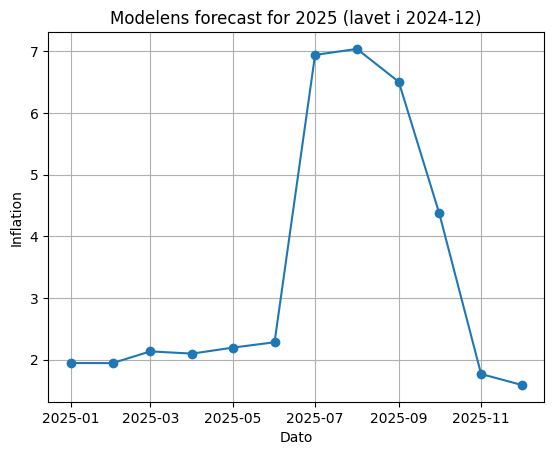

In [50]:
forecast_2025 = forecast_2025[forecast_2025["Dato"].dt.year == 2025]

plt.plot(forecast_2025["Dato"], forecast_2025["Inflationsforecast"], marker="o")
plt.title("Modelens forecast for 2025 (lavet i 2024-12)")
plt.ylabel("Inflation")
plt.xlabel("Dato")
plt.grid(True)
plt.show()